# A Study of Potential Influencing Factors on Canadian Immigrants
### CSCI 6405 -- Data Mining Project, Dalhousie University.
### By Hongwei Zhang, January - April 2023.

## Experiment 1: Study the reasons for Canadian immigrants leaving their home countries based on economic and social indicators for their countries.
### Data mining methods: Kmeans Clustering, Hierarchical Clustering
### Datasets used: The number of immigrants in Canada by country in the past ten years (2011-2021), and the economic and social indicators of the corresponding countries.

In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score

In [23]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)
im.replace('Russian Federation', 'Russia', inplace=True)
im.replace('United States of America', 'United States', inplace=True)

print("Number of country/region:", len(im))
im

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580
...,...,...,...,...,...
195,"Virgin Islands, United States",10,0,20,15
196,West Bank and Gaza Strip,1065,1930,2375,2620
197,Yemen,120,785,1120,2570
198,Zambia,480,685,780,845


In [24]:
# Filtering data from each dataset for 2011 and 2021.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011, GDP21 = GDP per capita for 2021.
life: Life expectancy at birth, total (years), LE11, LE21.
inflation: Inflation, consumer prices (annual %), IF11, IF21.
employment: Employment to population ratio, 15+, total (%), EM11, EM21.
female: Labor force participation rate, female (% of female population ages 15+), FM11, FM21.
health: Current health expenditure (% of GDP), HE11, HE21.
education: Government expenditure on education, total (% of GDP), ED11, ED21.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55, 65])
gdp.columns = ['Birthplace', 'GDP11', 'GDP21']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55, 65])
life.columns = ['LE11', 'LE21']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55, 65])
inflation.columns = ['IF11', 'IF21']
employment = pd.read_csv("Datasets/employment.csv", skiprows=4, usecols=[55, 65])
employment.columns = ['EM11', 'EM21']
female = pd.read_csv("Datasets/female.csv", skiprows=4, usecols=[55, 65])
female.columns = ['FM11', 'FM21']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55, 65])
health.columns = ['HE11', 'HE21']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55, 65])
education.columns = ['ED11', 'ED21']

comb = pd.concat([gdp, life, inflation, employment, female, health, education], axis=1)
comb.replace('Syrian Arab Republic', 'Syria', inplace=True)
comb.replace('Russian Federation', 'Russia', inplace=True)
comb.replace('Iran, Islamic Rep.', 'Iran', inplace=True)

print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Aruba,26044.435933,29342.100858,75.465000,NaN,4.316297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.11913,NaN
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,NaN,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.774233,NaN,4.38598,NaN
2,Afghanistan,621.912311,368.754614,61.419000,NaN,11.804186,NaN,43.180000,NaN,15.784000,NaN,8.561907,NaN,3.46201,NaN
3,Africa Western and Central,1856.687669,1757.030626,55.013138,NaN,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.547476,NaN,2.66890,NaN
4,Angola,4511.153227,1953.533757,57.596000,NaN,13.482468,25.754266,71.628998,68.557999,74.873001,74.463997,2.645608,NaN,3.03000,NaN


In [25]:
# Use the data imputation algorithm to fill in the missing data.

def imputation (file, data, col1, col2):  # csv file, table, index of the two columns need to be filled.
    f = pd.read_csv(file, skiprows=4, usecols=range(35, 66)).to_numpy()  # 1991-2021

    for i in range(len(data)):
        # Find the location of the missing data and read all data from the dataset for a certain time range.
        if math.isnan(data.iloc[[i], [col1]].values) or math.isnan(data.iloc[[i], [col2]].values):
            row = []
            for j in f[i]:
                if not math.isnan(j):
                    row.append(j)

            # If there are more than ten data exist, choose two data that are ten years apart.
            if len(row) >= 10:
                data.iloc[[i], [col1]] = row[len(row) - 10]
                data.iloc[[i], [col2]] = row[-1]

            # Otherwise, select the first and last one.
            elif 1 < len(row) < 10:
                data.iloc[[i], [col1]] = row[0]
                data.iloc[[i], [col2]] = row[-1]
            row.clear()


imputation("Datasets/gdp.csv", comb, 1, 2)
imputation("Datasets/life.csv", comb, 3, 4)
imputation("Datasets/inflation.csv", comb, 5, 6)
imputation("Datasets/employment.csv", comb, 7, 8)
imputation("Datasets/female.csv", comb, 9, 10)
imputation("Datasets/health.csv", comb, 11, 12)
imputation("Datasets/education.csv", comb, 13, 14)

# For countries or regions with too much missing data, they are removed because they cannot be imputed.
comb.dropna(axis=0,subset = ['GDP11', 'GDP21', 'LE11', 'LE21', 'IF11', 'IF21', 'EM11', 'EM21', 'FM11', 'FM21', 'HE11', 'HE21', 'ED11', 'ED21'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(comb))
comb

Number of country/region: 215


,Birthplace,GDP11,GDP21,LE11,LE21,IF11,IF21,EM11,EM21,FM11,FM21,HE11,HE21,ED11,ED21
0,Afghanistan,621.912311,368.754614,61.419000,62.575000,2.178538,2.302373,43.180000,36.710999,15.784000,16.462999,8.569672,13.242202,3.46201,2.860859
1,Africa Eastern and Southern,1792.847428,1537.336021,59.293271,63.313856,8.971206,6.079328,65.610090,64.030243,64.596561,64.434443,6.923020,6.272034,4.38598,4.608170
2,Africa Western and Central,1856.687669,1757.030626,55.013138,57.226373,4.018699,3.837868,61.222896,58.388407,57.979904,54.091940,3.519651,3.366086,2.66890,3.173885
3,Albania,4437.142612,6492.872012,78.092000,76.989000,3.429123,2.041472,51.860001,51.367001,52.467999,51.653000,4.602225,5.232072,3.08000,3.100000
4,Algeria,5473.280550,3690.627878,74.123000,74.453000,4.524212,7.226063,37.686001,35.349998,14.861000,15.909000,5.117172,6.243371,6.03000,7.042397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,Vietnam,1953.556979,3756.489121,73.692000,75.378000,18.677732,1.834716,75.507004,71.165001,71.575996,68.245003,4.699274,5.249656,4.81372,4.111617
211,World,10471.014284,12234.796802,71.007857,72.265011,4.822396,3.495058,58.026637,55.774031,48.762880,47.084343,9.494351,9.830195,4.24209,4.332050
212,"Yemen, Rep.",1045.805408,701.714878,67.419000,64.650000,11.811264,8.104726,33.438999,32.719002,8.753000,5.929000,5.529299,4.252858,9.64552,5.464790
213,Zambia,1644.456831,1137.343633,57.771000,62.380000,6.429397,22.021234,52.938000,56.868000,51.577999,54.028999,3.719296,5.312203,3.80000,3.702400


In [26]:
# Calculate the growth rate of the relevant data from 2011 to 2021.
def increase_rate(num1, num2):
    return float(format((num2 - num1) / num1, '.4f'))

# Generate the dataset to be used.
a0, a1, a2, a3, a4, a5, a6, a7, a8 = [], [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:

            a0.append(im['Birthplace'][n])
            a1.append(im['2011-2021'][n])

            a2.append(increase_rate(comb['GDP11'][m], comb['GDP21'][m]))
            a3.append(increase_rate(comb['LE11'][m], comb['LE21'][m]))
            a4.append(increase_rate(comb['IF11'][m], comb['IF21'][m]))
            a5.append(increase_rate(comb['EM11'][m], comb['EM21'][m]))
            a6.append(increase_rate(comb['FM11'][m], comb['FM21'][m]))
            a7.append(increase_rate(comb['HE11'][m], comb['HE21'][m]))
            a8.append(increase_rate(comb['ED11'][m], comb['ED21'][m]))

# The resulting dataset contains the number of immigrants in Canada from 2011 to 2021 by country or region,
# and the rate of change for each other indicator over the decade.

dataset = pd.DataFrame({'Birthplace':a0, 'Immigration':a1, 'GDP_Change':a2,
                        'LE_Change':a3, 'IF_Change':a4, 'EM_Change':a5,
                        'FM_Change':a6, 'HE_Change':a7, 'ED_Change':a8})
print("Number of country/region:", len(dataset))
dataset

Number of country/region: 141


,Birthplace,Immigration,GDP_Change,LE_Change,IF_Change,EM_Change,FM_Change,HE_Change,ED_Change
0,Afghanistan,21340,-0.4071,0.0188,0.0568,-0.1498,0.0430,0.5452,-0.1736
1,Albania,5500,0.4633,-0.0141,-0.4047,-0.0095,-0.0155,0.1369,0.0065
2,Algeria,32580,-0.3257,0.0045,0.5972,-0.0620,0.0705,0.2201,0.1679
3,Angola,580,-0.5670,0.0810,0.9102,-0.0429,-0.0055,-0.0600,-0.2029
4,Armenia,2120,0.4343,-0.0154,-0.0608,-0.0042,0.0415,0.2274,-0.1185
...,...,...,...,...,...,...,...,...,...
136,United States,70530,0.4031,-0.0173,0.4882,0.0108,-0.0257,0.0312,-0.0723
137,Uruguay,580,0.2135,0.0188,-0.0426,-0.0764,-0.0133,0.1816,0.0452
138,Uzbekistan,2250,-0.0332,0.0098,-0.2127,-0.0373,-0.0005,0.0758,-0.2055
139,Zambia,845,-0.3084,0.0798,2.4251,0.0742,0.0475,0.4283,-0.0257


In [27]:
# Normalize the number of immigrants so that the data falls between 0 and 1.
nor = normalize([dataset['Immigration']])

In [28]:
dataset.describe()

,Immigration,GDP_Change,LE_Change,IF_Change,EM_Change,FM_Change,HE_Change,ED_Change
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,15465.035461,0.184444,0.024806,0.572623,-0.002283,0.019436,0.074733,0.139049
std,48280.661925,0.430307,0.038637,4.017003,0.079638,0.097719,0.270183,0.411332
min,10.000000,-0.820500,-0.056900,-3.370100,-0.149800,-0.201700,-0.438200,-0.826800
25%,940.000000,-0.063300,0.002600,-0.474200,-0.051900,-0.027400,-0.060000,-0.073200
50%,2970.000000,0.118800,0.018100,-0.206900,-0.009500,0.008000,0.035800,0.049000
75%,8525.000000,0.399100,0.039000,0.192400,0.029600,0.064000,0.168600,0.274000
max,390965.000000,1.927000,0.238600,30.128700,0.312900,0.499600,1.392100,2.404700


<Axes: >

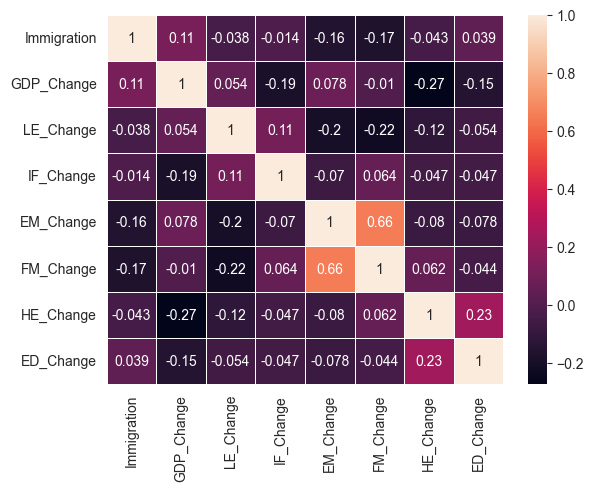

In [29]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

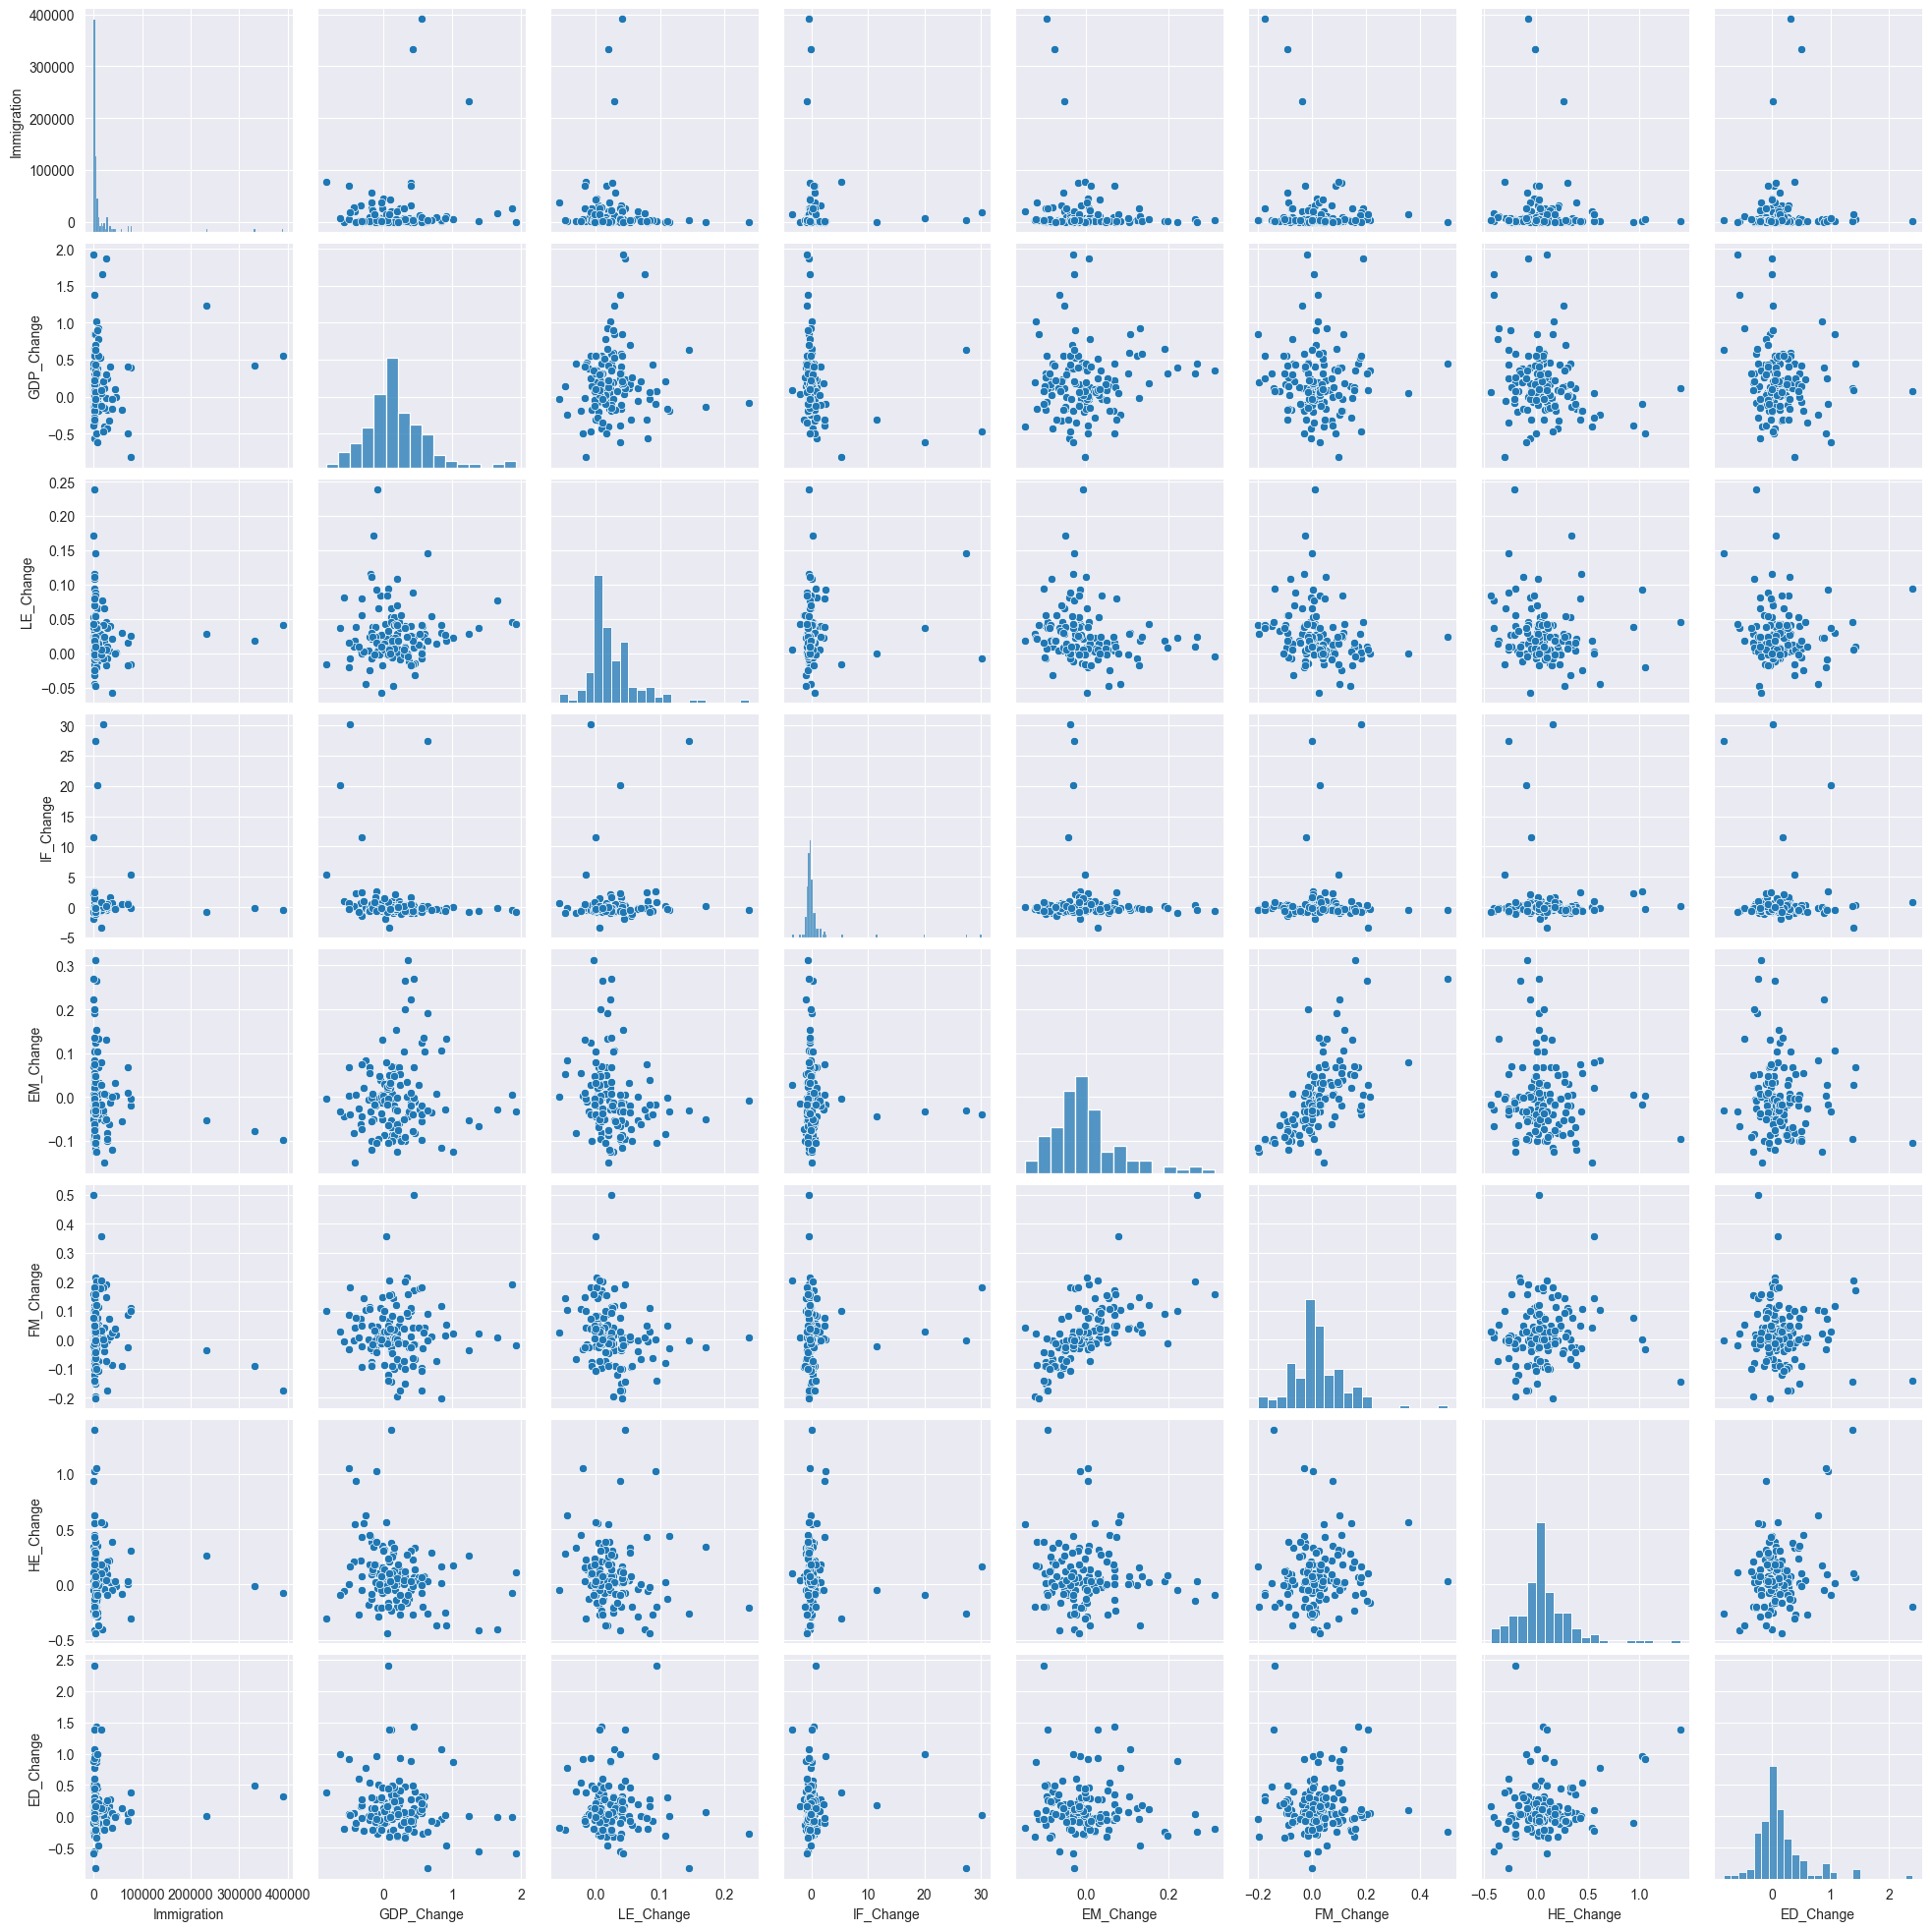

In [30]:
# Generate pairwise graphs based on the dataset.
sb.pairplot(dataset)

[Text(0.5, 0, 'Growth rate of government expenditure on education'),
 Text(0, 0.5, 'Country or Region')]

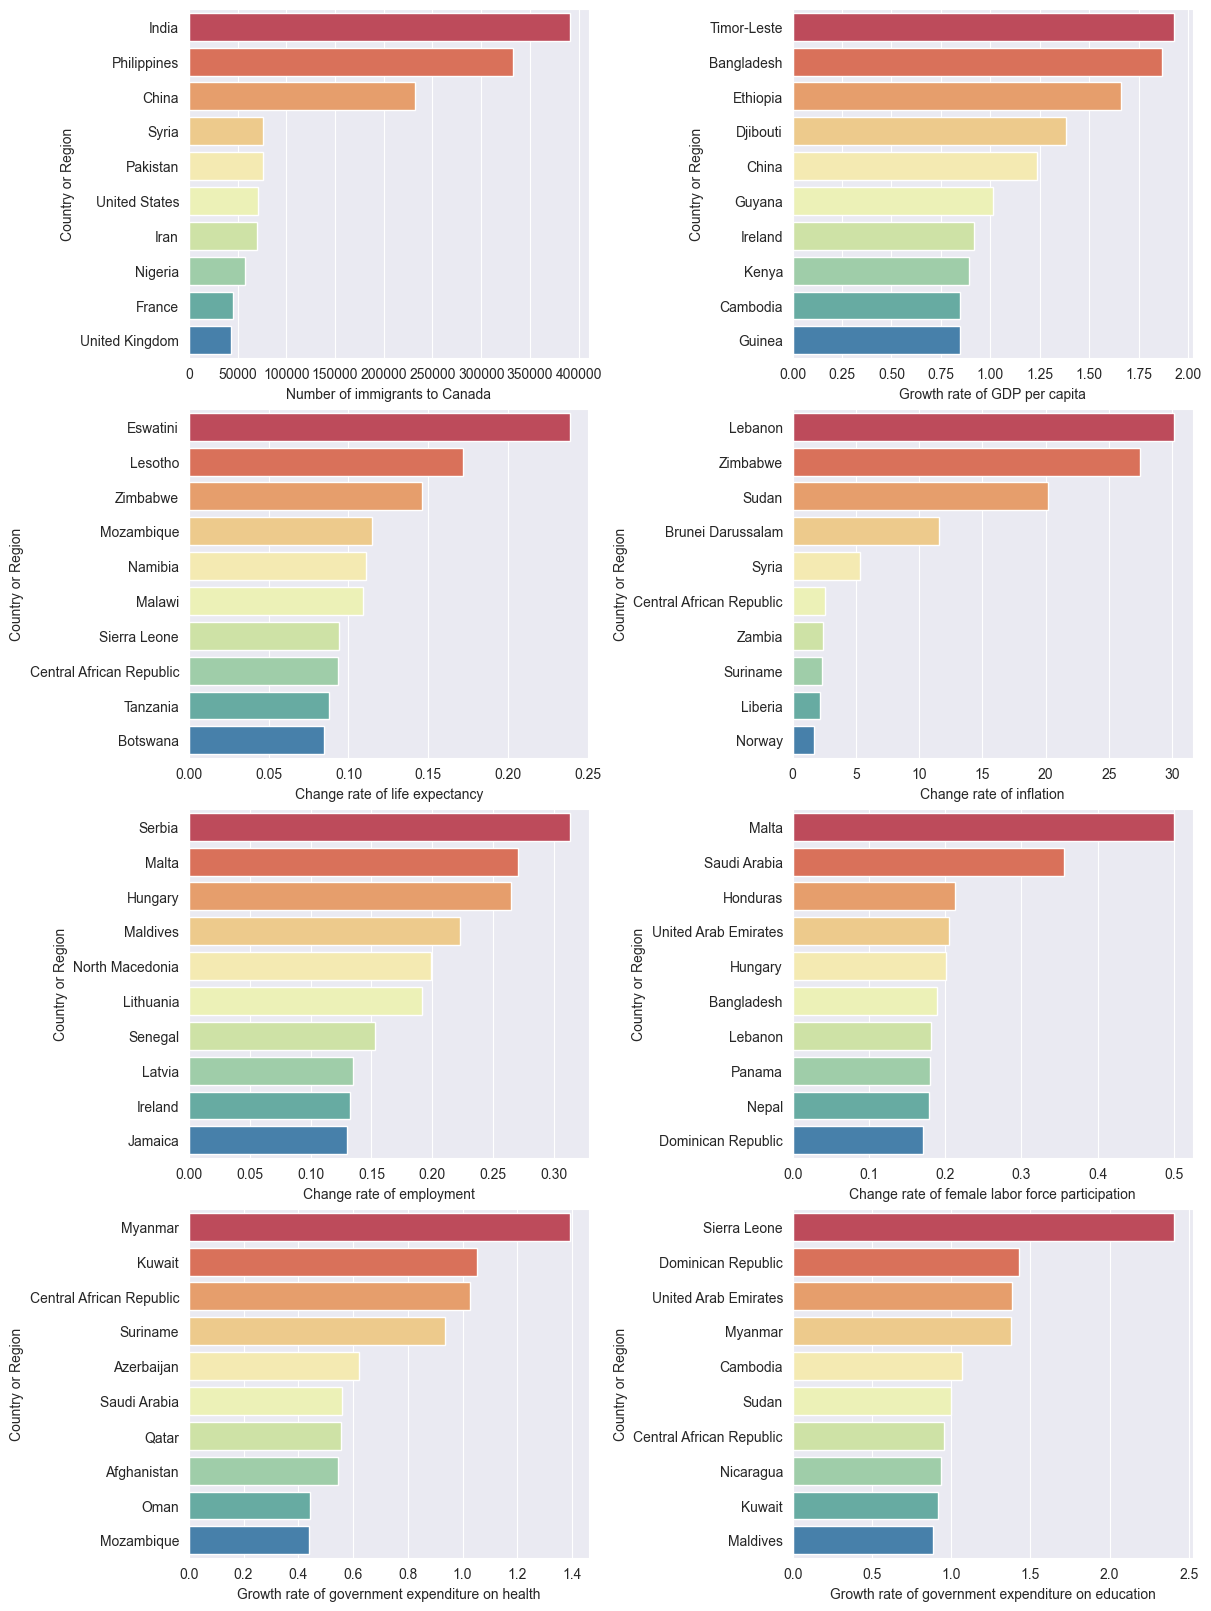

In [31]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')

sb.barplot(x='GDP_Change' ,y='Birthplace', data=dataset.nlargest(10, 'GDP_Change'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='Growth rate of GDP per capita', ylabel='Country or Region')

sb.barplot(x='LE_Change',y='Birthplace', data=dataset.nlargest(10, 'LE_Change'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Change rate of life expectancy', ylabel='Country or Region')

sb.barplot(x='IF_Change' ,y='Birthplace', data=dataset.nlargest(10, 'IF_Change'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Change rate of inflation', ylabel='Country or Region')

sb.barplot(x='EM_Change',y='Birthplace', data=dataset.nlargest(10, 'EM_Change'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Change rate of employment', ylabel='Country or Region')

sb.barplot(x='FM_Change',y='Birthplace', data=dataset.nlargest(10, 'FM_Change'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Change rate of female labor force participation', ylabel='Country or Region')

sb.barplot(x='HE_Change' ,y='Birthplace', data=dataset.nlargest(10, 'HE_Change'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on health', ylabel='Country or Region')

sb.barplot(x='ED_Change',y='Birthplace', data=dataset.nlargest(10, 'ED_Change'), ax=axes[3,1], palette="Spectral")\
    .set(xlabel='Growth rate of government expenditure on education', ylabel='Country or Region')

2 clusters, the silhouette score is 0.5454113566307498
3 clusters, the silhouette score is 0.500271086137759
4 clusters, the silhouette score is 0.5114951947029521
5 clusters, the silhouette score is 0.4847481423543601
6 clusters, the silhouette score is 0.4981577243917753


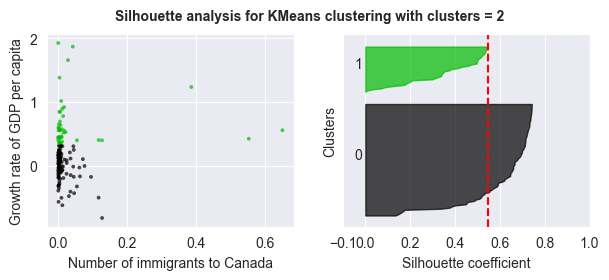

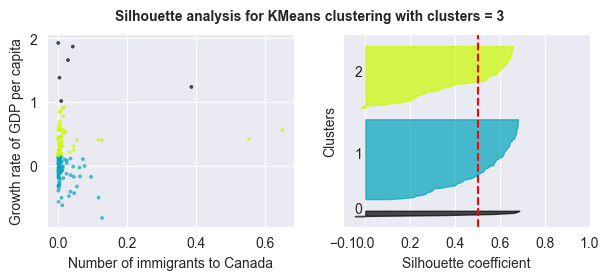

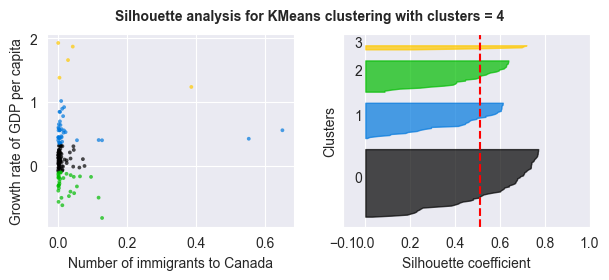

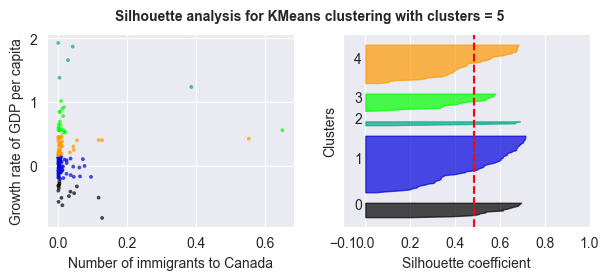

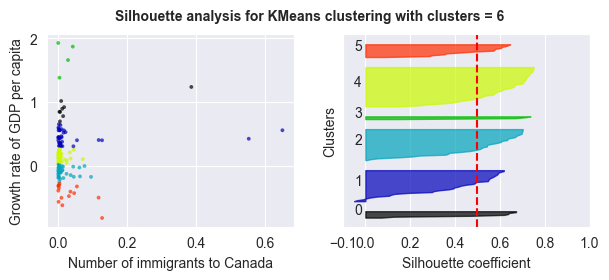

In [32]:
'''
Perform Kmeans clustering on the dataset, calculate the silhouette coefficients, and draw the silhouette plots.
The code used to draw the silhouette plots is from scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The results and silhouette plots from 2 clusters to 6 clusters are shown separately.
In order to find the most suitable number of clusters for clustering.
'''

for i in range(2, 7):
    X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':a2}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(7, 2.5)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])
    y_lower = 10

    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")
    ax2.axvline(x=silhouette, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("Growth rate of GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=10, fontweight="bold",)

plt.show()

In [33]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0

    for i in range(2, 7):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)

        if sil > score:
            score = sil
            n = i

    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []

        for k in range(len(a0)):
            if cx[k] == j:
                group.append(a0[k])

        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Immigrants')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.5454113566307498
Cluster 1: ['Afghanistan', 'Algeria', 'Angola', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Eswatini', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Greece', 'Guinea-Bissau', 'Hungary', 'Indonesia', 'Iran', 'Iraq', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lebanon', 'Lesotho', 'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Mauritania', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Paraguay', 'Peru', 'Poland', 'Portugal', 'Qatar', 'Russia', 'Rwanda', 'Saudi Arabia', 'Senegal', 'Sierra Leone', 

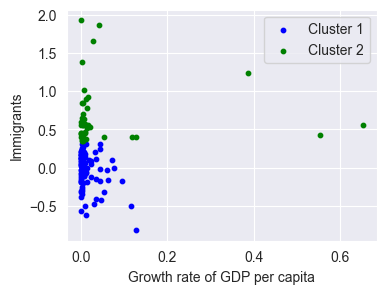

In [34]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':a2}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'Growth rate of GDP per capita')

2 clusters, the silhouette score is 0.8950108473427594
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

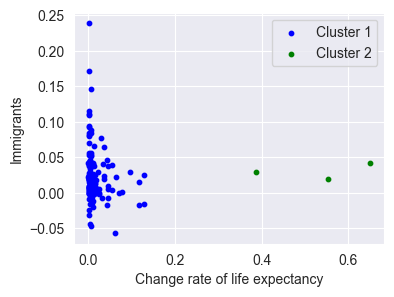

In [35]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':nor[0][:], 'LE_Change':a3}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Change rate of life expectancy')

2 clusters, the silhouette score is 0.9541181023991506
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 

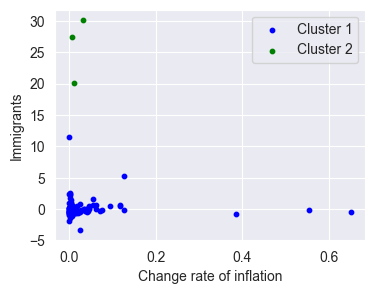

In [36]:
X3 = pd.DataFrame({'Immigration':nor[0][:], 'IF_Change':a4}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Change rate of inflation')

2 clusters, the silhouette score is 0.8202845434792454
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali',

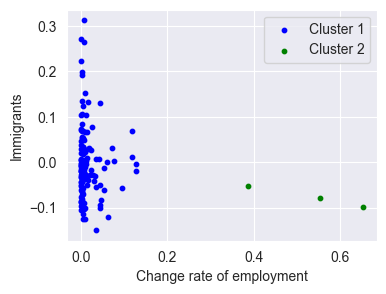

In [37]:
X4 = pd.DataFrame({'Immigration':nor[0][:], 'EM_Change':a5}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Change rate of employment')

2 clusters, the silhouette score is 0.794415938139114
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 

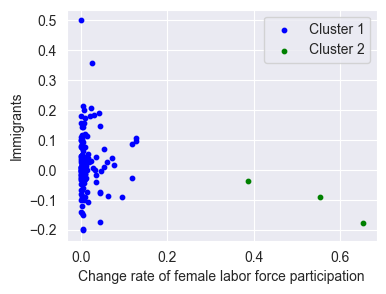

In [38]:
X5 = pd.DataFrame({'Immigration':nor[0][:], 'FM_Change':a6}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Change rate of female labor force participation')

2 clusters, the silhouette score is 0.5794569460003428
Cluster 1: ['Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Chad', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'Nicaragua', 'Niger', 'Nigeria', 'No

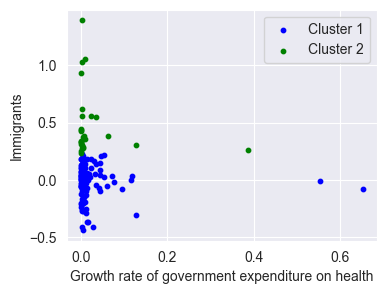

In [39]:
X6 = pd.DataFrame({'Immigration':nor[0][:], 'HE_Change':a7}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Growth rate of government expenditure on health')

2 clusters, the silhouette score is 0.688115723583815
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burundi', 'Cabo Verde', 'Cameroon', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco', 'Mozambique', 'Namibia', '

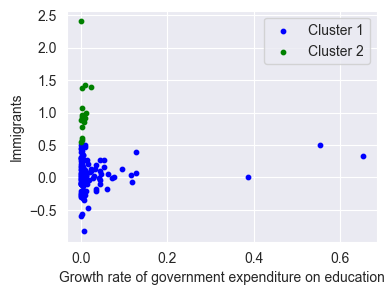

In [40]:
X7 = pd.DataFrame({'Immigration':nor[0][:], 'ED_Change':a8}).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'Growth rate of government expenditure on education')

2 clusters, the silhouette score is 0.937801601857952
Cluster 1: ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', '

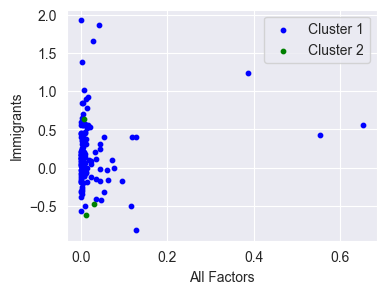

In [41]:
# Clustering with all other indicators using immigrants data.
X8 = pd.DataFrame({'Immigration':nor[0][:], 'GDP_Change':a2, 'LE_Change':a3, 'IF_Change':a4, 'EM_Change':a5, 'FM_Change':a6, 'HE_Change':a7, 'ED_Change':a8}).to_numpy()
plot_cluster(X8, choose_cluster(X8), 'All Factors')

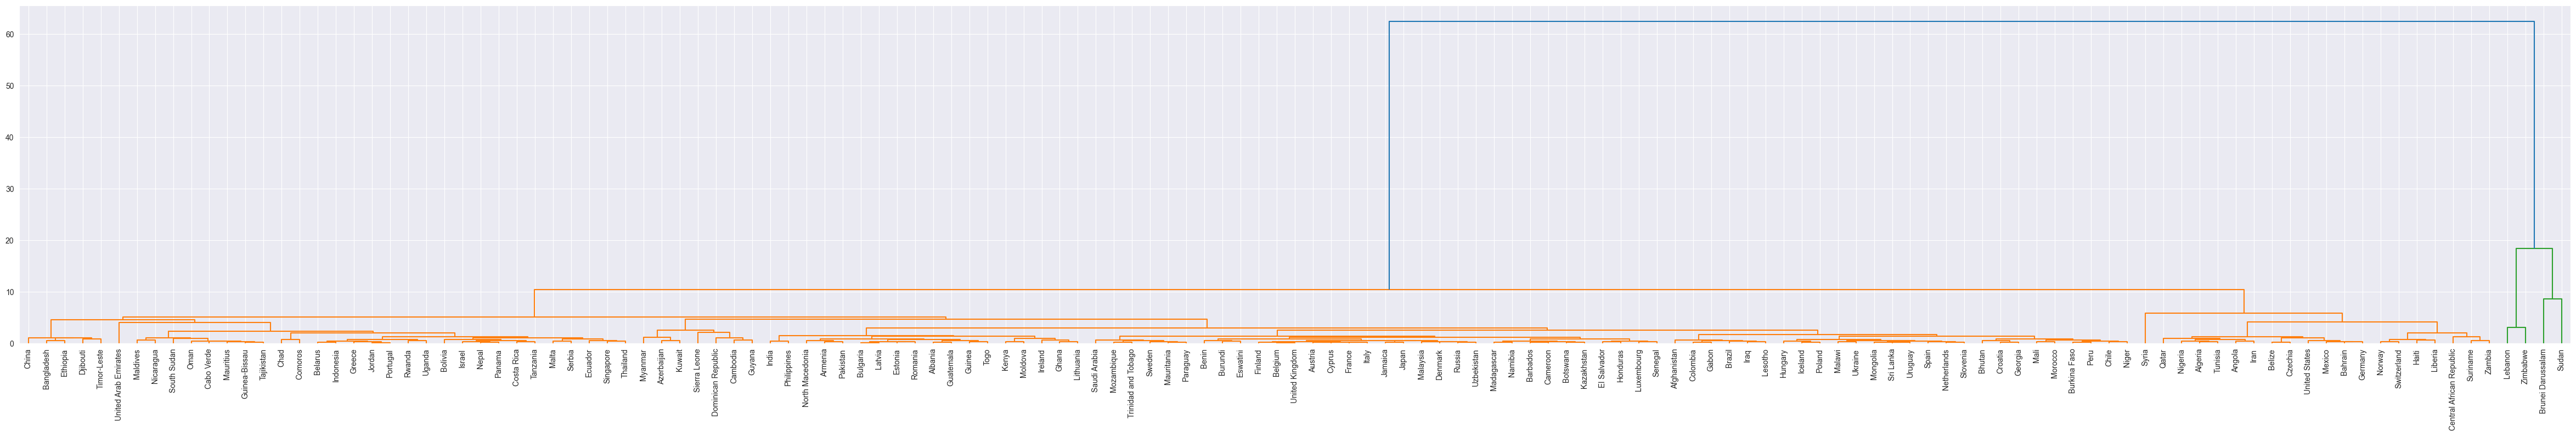

In [42]:
# Hierarchical clustering using the entire dataset.
plt.figure(figsize=(60, 8))
dend=sch.dendrogram(sch.linkage(X8, method='ward'), labels=a0, leaf_font_size=10)

### End of Experiments.